### Initialization of pandas dataframe

In [10]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

original_df = pd.read_csv("raw_data.csv")
original_df = original_df.drop(columns=['index'])

### Dropping Palawan rows since suspicious yung data nila

In [11]:
df = original_df[original_df['crop'] != 'PALAWAN, YELLOW, 1 KG']
df = df.query("month != 'Annual'")

In [12]:
df['category'].unique()

array(['CEREALS', 'ROOTCROPS', 'BEANS & LEGUMES', 'CONDIMENTS',
       'FRUIT VEGETABLES', 'LEAFY VEGETABLES', 'FRUITS',
       'COMMERCIAL CROPS', 'LIVESTOCK', 'POULTRY', 'FISH'], dtype=object)

### Convert Month and Year to numeric value

In [13]:
# Convert month to numeric
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['month_numeric'] = df['month'].map(month_dict)

# Combine month and year to a numeric column
df['month_year_numeric'] = df['year'] * 100 + df['month_numeric']

In [14]:
df

,crop,month,year,price,category,month_numeric,month_year_numeric
0,"RICE, WELL-MILLED, 1 KG",Jan,2020,43.02,CEREALS,1,202001
1,"RICE, WELL-MILLED, 1 KG",Feb,2020,42.86,CEREALS,2,202002
2,"RICE, WELL-MILLED, 1 KG",Mar,2020,42.66,CEREALS,3,202003
3,"RICE, WELL-MILLED, 1 KG",Apr,2020,43.61,CEREALS,4,202004
4,"RICE, WELL-MILLED, 1 KG",May,2020,43.88,CEREALS,5,202005
...,...,...,...,...,...,...,...
10446,"FRESH SEAWEEDS, LATO, 1 KG",Aug,2023,151.58,FISH,8,202308
10447,"FRESH SEAWEEDS, LATO, 1 KG",Sep,2023,151.16,FISH,9,202309
10448,"FRESH SEAWEEDS, LATO, 1 KG",Oct,2023,150.75,FISH,10,202310
10449,"FRESH SEAWEEDS, LATO, 1 KG",Nov,2023,151.58,FISH,11,202311


### Prepare Crop Combinations

In [15]:
from itertools import combinations
import numpy as np

# unique_categories = df['category'].unique()
# print(unique_categories)

# unique_crops = df.query("category == 'FISH'")
# unique_crops = unique_crops['crop'].unique()
# unique_crops = np.append("RICE, WELL-MILLED, 1 KG", unique_crops)

# print(unique_crops)
#unique_crops = df['crop'].unique()

unique_crops = ["RICE, WELL-MILLED, 1 KG",
                "WHOLE CORN GRAIN, YELLOW, 1 KG",
                "POTATO, 1 KG",
                "RAW PEANUT, SHELLED, 1 KG",
                "GINGER, LOOSE, 1 KG",
                "CHAYOTE, 1 KG",
                "CAMOTE TOPS, 1 KG",
                "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
                "YOUNG COCONUT, MEDIUM, 1 PC",
                "FRESH BEEF, PURE MEAT, 1 KG",
                "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
                "FRESH CHICKEN, NATIVE, 1 KG",
                "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
                "FRESH FISH, TILAPIA, MEDIUM, 1 KG",
                "FRESH SHRIMP, ACETES, MEDIUM, 1 KG"
            ]

crop_pairs = list(combinations(unique_crops, 2))
correlation_results = {}

### Compute Pearson correlation between the prices of the two crops

In [16]:
# Loop through each crop pair
for crop1, crop2 in crop_pairs:
    # Select data for the first crop
    
    # ###########################RICE ONLY FOR CROP 1################################
    # if crop1 != 'RICE, WELL-MILLED, 1 KG':
    #     continue
    # ###########################RICE ONLY FOR CROP 1################################
    
    crop1_data = df[df['crop'] == crop1]
    
    # Select data for the second crop
    crop2_data = df[df['crop'] == crop2]
    
    # if crop1_data['category'].unique() == crop2_data['category'].unique():
    #     continue
    
    # Merge data for the two crops based on 'year' and 'month'
    merged_data = pd.merge(crop1_data, crop2_data, on=['year', 'month'])
    
    # Compute Pearson correlation between the prices of the two crops
    correlation = merged_data['price_x'].corr(merged_data['price_y'])
    
    # Store the correlation coefficient in the dictionary
    correlation_results[(crop1, crop2)] = correlation

# Convert dictionary to DataFrame for easier analysis
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson Correlation'])

### Create a correlation matrix

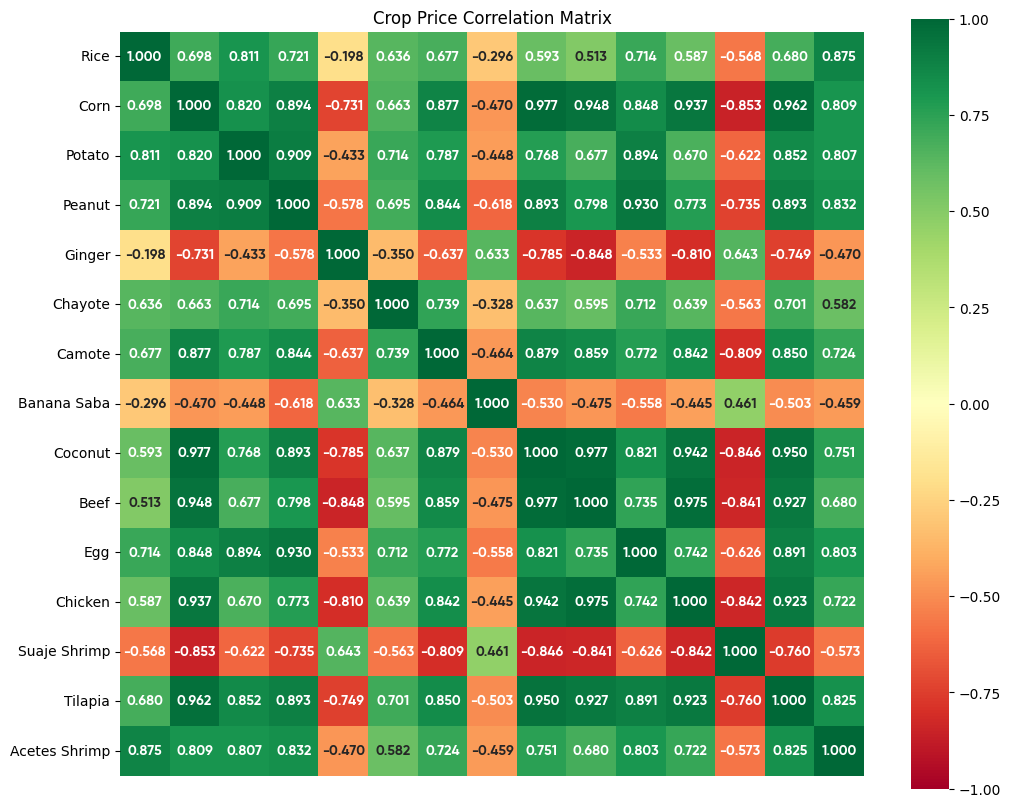

In [21]:
correlation_matrix = pd.DataFrame(index=unique_crops, columns=unique_crops)

# Fill in the correlation matrix
for (crop1, crop2), correlation in correlation_results.items():
    correlation_matrix.at[crop1, crop2] = correlation
    correlation_matrix.at[crop2, crop1] = correlation

# Ensure diagonal values are 1 (self-correlation)
for crop in unique_crops:
    correlation_matrix.at[crop, crop] = 1

# Optionally, visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Rice','Corn','Potato','Peanut','Ginger','Chayote','Camote','Banana Saba','Coconut','Beef','Egg','Chicken','Suaje Shrimp','Tilapia','Acetes Shrimp']
custom = sns.diverging_palette(145, 300, s=60, as_cmap=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
BuRd = plt.cm.RdBu_r
plt.figure(figsize=(12, 10))
sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix.astype(float), 
            mask=mask,
            annot=True, 
            cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1,
            linewidths=0, 
            fmt=".3f",
            xticklabels=False,
            yticklabels=labels,
            square=True,
            cbar=True,
            cbar_kws={
            },
            annot_kws={
                'fontsize':10,
                'fontweight':'bold',
                'fontfamily' : 'Gilroy',
            },
            )
plt.title('Crop Price Correlation Matrix')
plt.show()

### Print correlations

In [18]:
sorted_correlation_df = correlation_df.sort_values(by='Pearson Correlation', ascending=False)

# Display the top 10 correlations
print("Top correlations:")
sorted_correlation_df.head(20)

Top correlations:


,Pearson Correlation
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH BEEF, PURE MEAT, 1 KG)",0.977082
"(WHOLE CORN GRAIN, YELLOW, 1 KG, YOUNG COCONUT, MEDIUM, 1 PC)",0.976660
"(FRESH BEEF, PURE MEAT, 1 KG, FRESH CHICKEN, NATIVE, 1 KG)",0.974549
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.961580
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.950468
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH BEEF, PURE MEAT, 1 KG)",0.947860
"(YOUNG COCONUT, MEDIUM, 1 PC, FRESH CHICKEN, NATIVE, 1 KG)",0.942305
"(WHOLE CORN GRAIN, YELLOW, 1 KG, FRESH CHICKEN, NATIVE, 1 KG)",0.936554
"(RAW PEANUT, SHELLED, 1 KG, FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC)",0.930207
"(FRESH BEEF, PURE MEAT, 1 KG, FRESH FISH, TILAPIA, MEDIUM, 1 KG)",0.926681


### Kruskal Willis Test for seasonality (function)

In [19]:
from scipy.stats import kruskal
import calendar

def seasonality_analysis(df, unique_crops):
    results = []

    for crop in unique_crops:
        crop_data = df[df['crop'] == crop]

        # Monthly mean and standard deviation
        monthly_stats = crop_data.groupby('month')['price'].agg(['mean', 'std']).reset_index()
        
        # Sort months from January to December
        months_ordered = [month for month in calendar.month_abbr if month in monthly_stats['month'].unique()]
        monthly_stats = monthly_stats.set_index('month').loc[months_ordered].reset_index()

        # Overall mean and standard deviation
        overall_mean = crop_data['price'].mean()
        overall_std = crop_data['price'].std()

        # Difference between each month's average and overall average
        monthly_diff_from_overall_mean = monthly_stats['mean'] - overall_mean
        
        # Number of standard deviations each month's average differs from overall average
        sigma_diff_from_overall_mean = monthly_diff_from_overall_mean / overall_std
        
        # Kruskal-Wallis test
        grouped_data = [crop_data[crop_data['month'] == month]['price'].values for month in months_ordered]
        h_stat, p_value = kruskal(*grouped_data)
        seasonal = 'Yes' if p_value < 0.05 else 'No'
        
        # Store results
        results.append({
            'crop': crop,
            'seasonal?': seasonal,
            'mean_per_month': monthly_stats['mean'].tolist(),
            'months': monthly_stats['month'].tolist(),
            'sigma_diff_from_overall_mean': sigma_diff_from_overall_mean.tolist()
        })
    
    return results

seasonality_results = seasonality_analysis(df, unique_crops)
seasonality_results


[{'crop': 'RICE, WELL-MILLED, 1 KG',
  'seasonal?': 'No',
  'mean_per_month': [43.227500000000006,
   43.25,
   43.2925,
   43.645,
   43.815,
   43.965,
   44.1175,
   44.7575,
   45.9225,
   45.385000000000005,
   45.5975,
   46.0725],
  'months': ['Jan',
   'Feb',
   'Mar',
   'Apr',
   'May',
   'Jun',
   'Jul',
   'Aug',
   'Sep',
   'Oct',
   'Nov',
   'Dec'],
  'sigma_diff_from_overall_mean': [-0.46434867428355536,
   -0.45559196801105484,
   -0.4390515228296616,
   -0.30186312456044595,
   -0.2357013438348701,
   -0.17732330201818144,
   -0.11797229283788499,
   0.13110735224664408,
   0.5845101436895752,
   0.3753221605131176,
   0.45802438642008675,
   0.642888185506261]},
 {'crop': 'WHOLE CORN GRAIN, YELLOW, 1 KG',
  'seasonal?': 'No',
  'mean_per_month': [33.5325,
   33.5475,
   33.795,
   34.1125,
   34.2375,
   34.4125,
   34.5275,
   34.8525,
   35.265,
   35.6975,
   35.685,
   35.9375],
  'months': ['Jan',
   'Feb',
   'Mar',
   'Apr',
   'May',
   'Jun',
   'Jul',
   

### Plot into graph

Original, everything combined

RICE, WELL-MILLED, 1 KG:
Jan: -0.464
Feb: -0.456
Mar: -0.439
Apr: -0.302
May: -0.236
Jun: -0.177
Jul: -0.118
Aug: 0.131
Sep: 0.585
Oct: 0.375
Nov: 0.458
Dec: 0.643
WHOLE CORN GRAIN, YELLOW, 1 KG:
Jan: -0.348
Feb: -0.343
Mar: -0.265
Apr: -0.165
May: -0.125
Jun: -0.07
Jul: -0.033
Aug: 0.069
Sep: 0.199
Oct: 0.336
Nov: 0.332
Dec: 0.412
POTATO, 1 KG:
Jan: 0.199
Feb: 0.085
Mar: -0.12
Apr: -0.203
May: -0.341
Jun: -0.396
Jul: -0.333
Aug: -0.154
Sep: -0.096
Oct: 0.166
Nov: 0.536
Dec: 0.658
RAW PEANUT, SHELLED, 1 KG:
Jan: -0.098
Feb: -0.152
Mar: -0.215
Apr: -0.376
May: -0.28
Jun: -0.224
Jul: -0.01
Aug: 0.146
Sep: 0.206
Oct: 0.21
Nov: 0.349
Dec: 0.444
GINGER, LOOSE, 1 KG:
Jan: -0.087
Feb: -0.243
Mar: -0.387
Apr: -0.068
May: 0.004
Jun: 0.118
Jul: 0.177
Aug: 0.218
Sep: 0.142
Oct: 0.129
Nov: 0.084
Dec: -0.086
CHAYOTE, 1 KG:
Jan: 0.083
Feb: -0.003
Mar: -0.463
Apr: -0.454
May: -0.233
Jun: -0.182
Jul: -0.089
Aug: -0.064
Sep: 0.751
Oct: 0.207
Nov: 0.145
Dec: 0.301
CAMOTE TOPS, 1 KG:
Jan: 0.072
Feb: -0.1

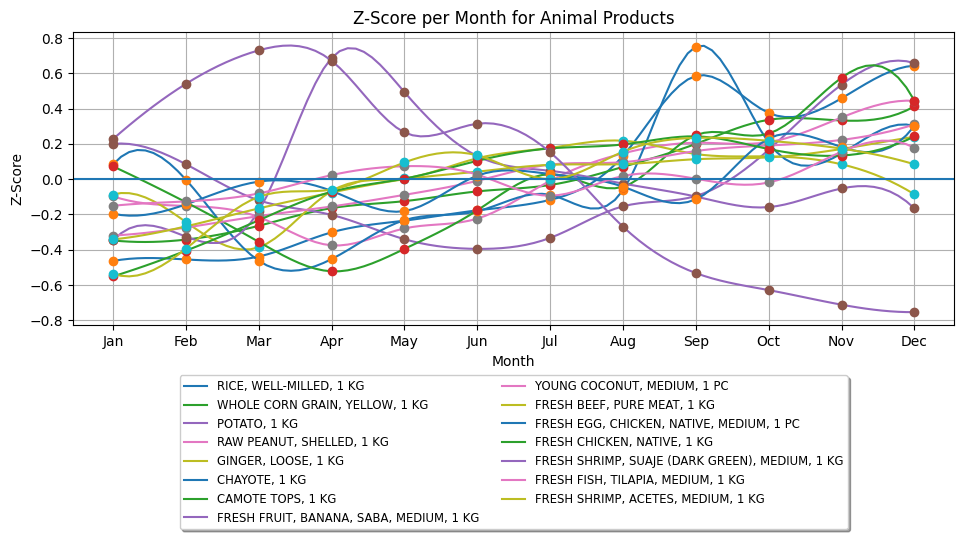

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:
        
        unique_crops = ["RICE, WELL-MILLED, 1 KG",
                "WHOLE CORN GRAIN, YELLOW, 1 KG",
                "POTATO, 1 KG",
                "RAW PEANUT, SHELLED, 1 KG",
                "GINGER, LOOSE, 1 KG",
                "CHAYOTE, 1 KG",
                "CAMOTE TOPS, 1 KG",
                "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
                "YOUNG COCONUT, MEDIUM, 1 PC",
                "FRESH BEEF, PURE MEAT, 1 KG",
                "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
                "FRESH CHICKEN, NATIVE, 1 KG",
                "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
                "FRESH FISH, TILAPIA, MEDIUM, 1 KG",
                "FRESH SHRIMP, ACETES, MEDIUM, 1 KG"
            ]
        # crops_to_plot = [
        #     'RICE, WELL-MILLED, 1 KG',
        #     'CAULIFLOWER, 1 KG',
        #     'FRESH FRUIT, MANGO, KALABAW, RIPE, MEDIUM, 1 KG',
        #     'FRESH FRUIT, GRAPES, 1 KG',
        #     'FRESH SHRIMP, SUAJE, MEDIUM, 1 KG'
        # ]
        # if result['crop'] not in crops_to_plot:
        #     continue
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        print(f"{crop}:")
        for i in range (12):
            print(f"{months[i]}: {round(sd_diff[i],3)}")
        
        # Convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # Interpolation using cubic splines
        spline = splrep(month_numbers, sd_diff, k=3)  # k=3 for cubic spline
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        # Plot the smooth line
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        # Plot the original data points
        plt.plot(month_numbers, sd_diff, 'o')
        

    plt.title('Z-Score per Month for Animal Products')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()
    
            
plot_sd_difference(seasonality_results)


Group A: Grains and Starches

RICE, WELL-MILLED, 1 KG:
Jan: -0.464
Feb: -0.456
Mar: -0.439
Apr: -0.302
May: -0.236
Jun: -0.177
Jul: -0.118
Aug: 0.131
Sep: 0.585
Oct: 0.375
Nov: 0.458
Dec: 0.643
WHOLE CORN GRAIN, YELLOW, 1 KG:
Jan: -0.348
Feb: -0.343
Mar: -0.265
Apr: -0.165
May: -0.125
Jun: -0.07
Jul: -0.033
Aug: 0.069
Sep: 0.199
Oct: 0.336
Nov: 0.332
Dec: 0.412
POTATO, 1 KG:
Jan: 0.199
Feb: 0.085
Mar: -0.12
Apr: -0.203
May: -0.341
Jun: -0.396
Jul: -0.333
Aug: -0.154
Sep: -0.096
Oct: 0.166
Nov: 0.536
Dec: 0.658
RAW PEANUT, SHELLED, 1 KG:
Jan: -0.098
Feb: -0.152
Mar: -0.215
Apr: -0.376
May: -0.28
Jun: -0.224
Jul: -0.01
Aug: 0.146
Sep: 0.206
Oct: 0.21
Nov: 0.349
Dec: 0.444


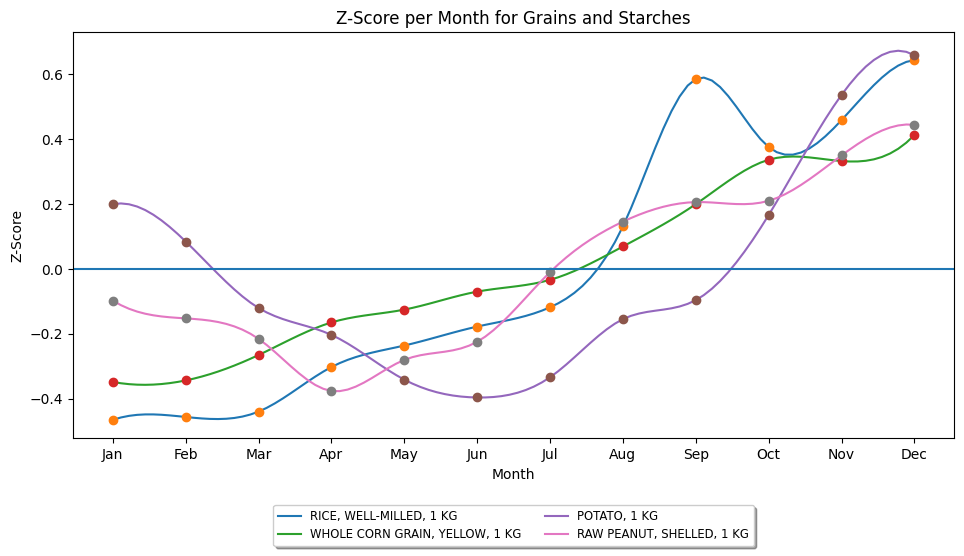

In [24]:
def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:     
        
        crops_to_plot = [
            "RICE, WELL-MILLED, 1 KG",
            "WHOLE CORN GRAIN, YELLOW, 1 KG",
            "POTATO, 1 KG",
            "RAW PEANUT, SHELLED, 1 KG"
        ]
        if result['crop'] not in crops_to_plot:
            continue
        
        
        
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        print(f"{crop}:")
        for i in range (12):
            print(f"{months[i]}: {round(sd_diff[i],3)}")
        
        # Convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # Interpolation using cubic splines
        spline = splrep(month_numbers, sd_diff, k=3)  # k=3 for cubic spline
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        # Plot the smooth line
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        # Plot the original data points
        plt.plot(month_numbers, sd_diff, 'o')
        

    plt.title('Z-Score per Month for Grains and Starches')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(False)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()
    
            
plot_sd_difference(seasonality_results)


Group B: Fruit, Vegetables, Roots

GINGER, LOOSE, 1 KG:
Jan: -0.087
Feb: -0.243
Mar: -0.387
Apr: -0.068
May: 0.004
Jun: 0.118
Jul: 0.177
Aug: 0.218
Sep: 0.142
Oct: 0.129
Nov: 0.084
Dec: -0.086
CHAYOTE, 1 KG:
Jan: 0.083
Feb: -0.003
Mar: -0.463
Apr: -0.454
May: -0.233
Jun: -0.182
Jul: -0.089
Aug: -0.064
Sep: 0.751
Oct: 0.207
Nov: 0.145
Dec: 0.301
CAMOTE TOPS, 1 KG:
Jan: 0.072
Feb: -0.131
Mar: -0.356
Apr: -0.523
May: -0.396
Jun: -0.177
Jul: 0.027
Aug: -0.044
Sep: 0.249
Oct: 0.258
Nov: 0.575
Dec: 0.445
FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG:
Jan: -0.348
Feb: -0.326
Mar: -0.181
Apr: 0.687
May: 0.493
Jun: 0.13
Jul: 0.047
Aug: -0.025
Sep: -0.099
Oct: -0.159
Nov: -0.053
Dec: -0.166
YOUNG COCONUT, MEDIUM, 1 PC:
Jan: -0.32
Feb: -0.275
Mar: -0.21
Apr: -0.155
May: -0.089
Jun: -0.01
Jul: 0.082
Aug: 0.096
Sep: 0.159
Oct: 0.191
Nov: 0.222
Dec: 0.31


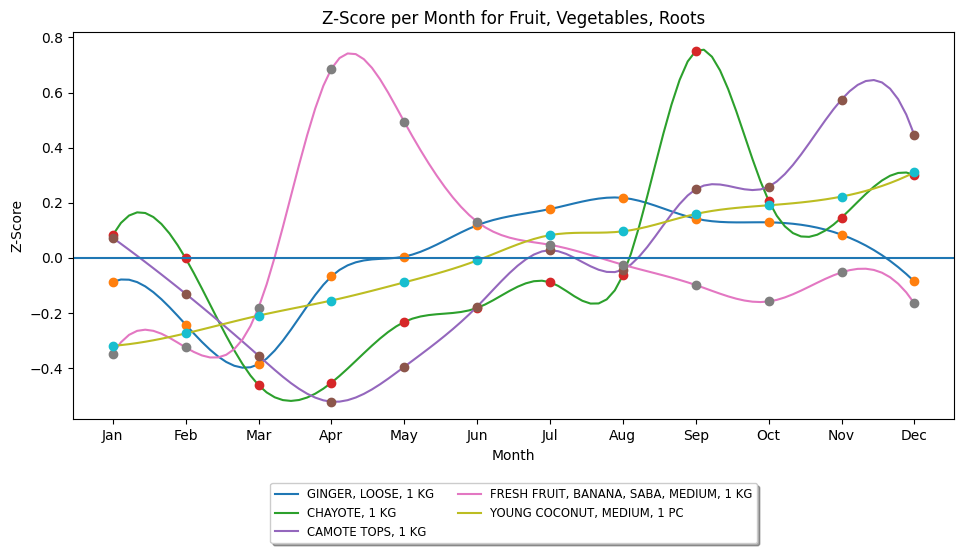

In [23]:
def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:        
        
        crops_to_plot = [
            "GINGER, LOOSE, 1 KG",
            "CHAYOTE, 1 KG",
            "CAMOTE TOPS, 1 KG",
            "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
            "YOUNG COCONUT, MEDIUM, 1 PC"         
        ]
        if result['crop'] not in crops_to_plot:
            continue
        
        
        
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        print(f"{crop}:")
        for i in range (12):
            print(f"{months[i]}: {round(sd_diff[i],3)}")
        
        # Convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # Interpolation using cubic splines
        spline = splrep(month_numbers, sd_diff, k=3)  # k=3 for cubic spline
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        # Plot the smooth line
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        # Plot the original data points
        plt.plot(month_numbers, sd_diff, 'o')
        

    plt.title('Z-Score per Month for Fruit, Vegetables, Roots')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(False)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()
    
            
plot_sd_difference(seasonality_results)


Group C: Animal Products

FRESH BEEF, PURE MEAT, 1 KG:
Jan: -0.342
Feb: -0.268
Mar: -0.166
Apr: -0.076
May: -0.001
Jun: 0.042
Jul: 0.081
Aug: 0.085
Sep: 0.113
Oct: 0.123
Nov: 0.171
Dec: 0.24
FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC:
Jan: -0.196
Feb: -0.143
Mar: -0.014
Apr: -0.067
May: -0.182
Jun: 0.019
Jul: 0.029
Aug: -0.043
Sep: -0.115
Oct: 0.229
Nov: 0.182
Dec: 0.301
FRESH CHICKEN, NATIVE, 1 KG:
Jan: -0.552
Feb: -0.406
Mar: -0.234
Apr: -0.072
May: 0.003
Jun: 0.103
Jul: 0.174
Aug: 0.196
Sep: 0.242
Oct: 0.17
Nov: 0.133
Dec: 0.241


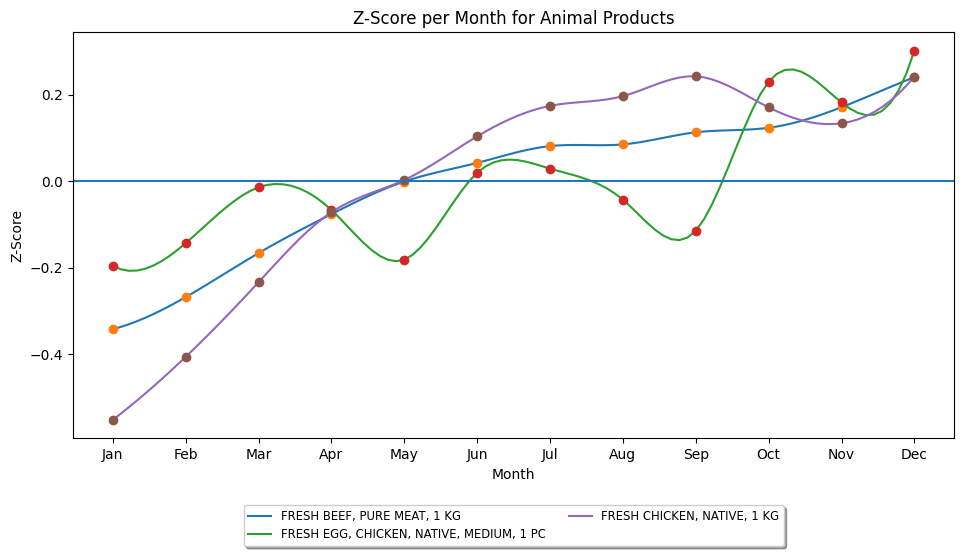

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:        
        
        crops_to_plot = [
            "FRESH BEEF, PURE MEAT, 1 KG",
            "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
            "FRESH CHICKEN, NATIVE, 1 KG",         
        ]
        if result['crop'] not in crops_to_plot:
            continue
        
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        print(f"{crop}:")
        for i in range (12):
            print(f"{months[i]}: {round(sd_diff[i],3)}")
        
        # Convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # Interpolation using cubic splines
        spline = splrep(month_numbers, sd_diff, k=3)  # k=3 for cubic spline
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        # Plot the smooth line
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        # Plot the original data points
        plt.plot(month_numbers, sd_diff, 'o')
        

    plt.title('Z-Score per Month for Animal Products')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(False)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()
    
            
plot_sd_difference(seasonality_results)


Group D: Seafood

FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG:
Jan: 0.227
Feb: 0.54
Mar: 0.73
Apr: 0.671
May: 0.265
Jun: 0.314
Jul: 0.152
Aug: -0.27
Sep: -0.533
Oct: -0.629
Nov: -0.712
Dec: -0.754
FRESH FISH, TILAPIA, MEDIUM, 1 KG:
Jan: -0.151
Feb: -0.127
Mar: -0.081
Apr: 0.022
May: 0.073
Jun: 0.025
Jul: -0.094
Aug: 0.018
Sep: 0.002
Oct: -0.019
Nov: 0.155
Dec: 0.178
FRESH SHRIMP, ACETES, MEDIUM, 1 KG:
Jan: -0.536
Feb: -0.395
Mar: -0.101
Apr: -0.059
May: 0.094
Jun: 0.135
Jul: -0.0
Aug: 0.155
Sep: 0.234
Oct: 0.217
Nov: 0.173
Dec: 0.084


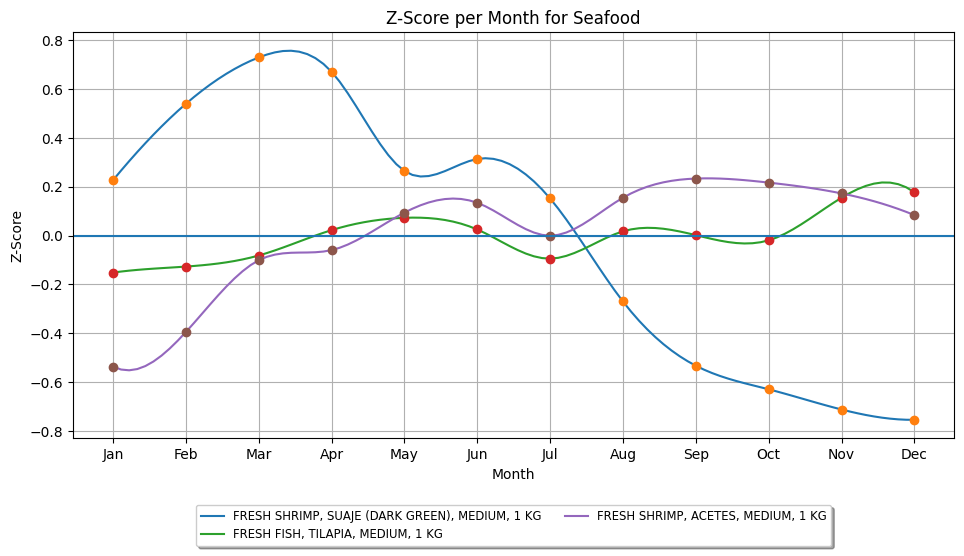

In [28]:

def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))

    for result in seasonality_results:        
        
        crops_to_plot = [
            "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
            "FRESH SHRIMP, ACETES, MEDIUM, 1 KG",
            "FRESH FISH, TILAPIA, MEDIUM, 1 KG"           
        ]
        if result['crop'] not in crops_to_plot:
            continue
        
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        
        print(f"{crop}:")
        for i in range(12):
            print(f"{months[i]}: {round(sd_diff[i],3)}")
        
        # Convert month names to numerical values for interpolation
        month_numbers = np.arange(1, 13)
        
        # Interpolation using cubic splines
        spline = splrep(month_numbers, sd_diff, k=3)  # k=3 for cubic spline
        smooth_months = np.linspace(1, 12, 100)
        smooth_sd_diff = splev(smooth_months, spline)
        
        # Plot the smooth line
        plt.plot(smooth_months, smooth_sd_diff, label=crop)
        # Plot the original data points
        plt.plot(month_numbers, sd_diff, 'o')
        
    plt.title('Z-Score per Month for Seafood')
    plt.xlabel('Month')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()

plot_sd_difference(seasonality_results)


### Broken Horizontal Bars for Nutshell

In [16]:
# I want to show peak months for each unique crop
from statistics import mean

for result in seasonality_results:
    crop = result['crop']
    average_price = mean(result['mean_per_month'])
    print(f"{crop}: {average_price}")
    
    for i in range(12):
        if result['mean_per_month'][i] > average_price:
            print(f"Peak month: {result['months'][i]}")
    

RICE, WELL-MILLED, 1 KG: 44.420625
Peak month: Aug
Peak month: Sep
Peak month: Oct
Peak month: Nov
Peak month: Dec
WHOLE CORN GRAIN, YELLOW, 1 KG: 34.633541666666666
Peak month: Aug
Peak month: Sep
Peak month: Oct
Peak month: Nov
Peak month: Dec
POTATO, 1 KG: 105.150625
Peak month: Jan
Peak month: Feb
Peak month: Oct
Peak month: Nov
Peak month: Dec
RAW PEANUT, SHELLED, 1 KG: 106.87333333333333
Peak month: Aug
Peak month: Sep
Peak month: Oct
Peak month: Nov
Peak month: Dec
GINGER, LOOSE, 1 KG: 116.42729166666666
Peak month: May
Peak month: Jun
Peak month: Jul
Peak month: Aug
Peak month: Sep
Peak month: Oct
Peak month: Nov
CHAYOTE, 1 KG: 38.76145833333333
Peak month: Jan
Peak month: Sep
Peak month: Oct
Peak month: Nov
Peak month: Dec
CAMOTE TOPS, 1 KG: 39.50354166666666
Peak month: Jan
Peak month: Jul
Peak month: Sep
Peak month: Oct
Peak month: Nov
Peak month: Dec
FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG: 37.923125
Peak month: Apr
Peak month: May
Peak month: Jun
Peak month: Jul
YOUNG COCO

RICE, WELL-MILLED, 1 KG: 44.420625
WHOLE CORN GRAIN, YELLOW, 1 KG: 34.633541666666666
RAW PEANUT, SHELLED, 1 KG: 106.87333333333333
YOUNG COCONUT, MEDIUM, 1 PC: 27.072916666666668
FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC: 8.49
FRESH BEEF, PURE MEAT, 1 KG: 362.8772916666667
FRESH CHICKEN, NATIVE, 1 KG: 238.85375
FRESH SHRIMP, ACETES, MEDIUM, 1 KG: 238.75520833333334
GINGER, LOOSE, 1 KG: 116.42729166666666
FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG: 37.923125
FRESH FISH, TILAPIA, MEDIUM, 1 KG: 152.50083333333333
CAMOTE TOPS, 1 KG: 39.50354166666666
CHAYOTE, 1 KG: 38.76145833333333
POTATO, 1 KG: 105.150625
FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG: 357.46750000000003


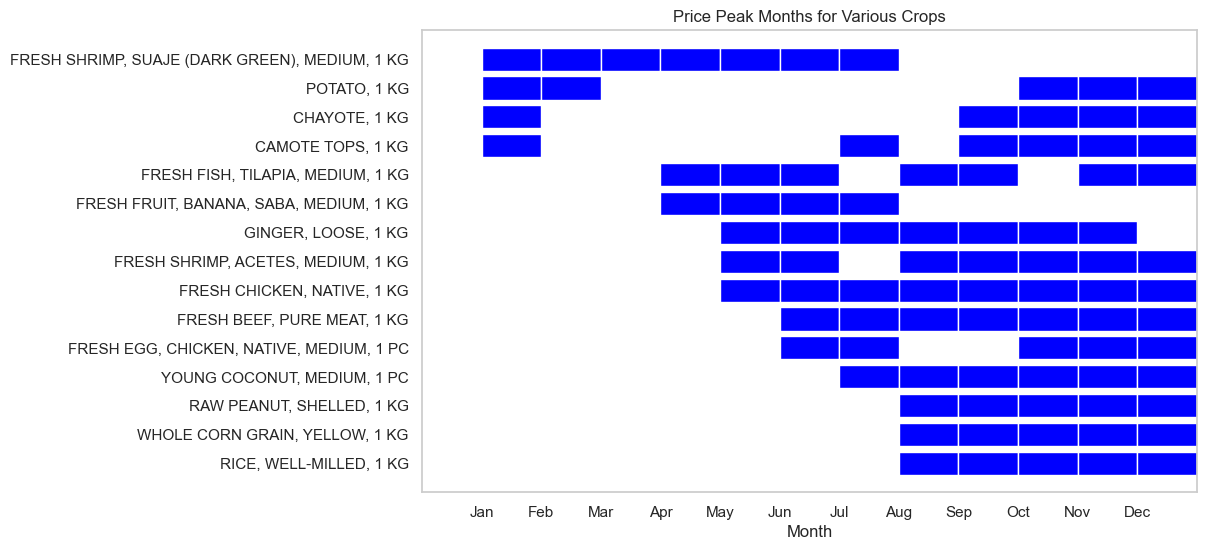

In [51]:
# Create the plot
seasonality_results = seasonality_analysis(df, unique_crops)
seasonality_results

fig, ax = plt.subplots(figsize=(10, 6))

def swap(x, y):
    seasonality_results[x], seasonality_results[y] = seasonality_results[y], seasonality_results[x]

swap(12,14)
swap(2,13)
swap(5,12)
swap(6,11)
swap(2,10)
swap(7,9)
swap(4,8)
swap(5,7)
swap(2,4)
swap(2,3)


# Define y-axis position for each crop
crop_positions = {result['crop']: i for i, result in enumerate(seasonality_results)}

for result in seasonality_results:
    crop = result['crop']
    average_price = mean(result['mean_per_month'])
    print(f"{crop}: {average_price}")

    for i in range(12):
        month = result['months'][i]
        month_num = i + 1
        if result['mean_per_month'][i] > average_price:
            ax.broken_barh([(month_num, 1)], (crop_positions[crop] - 0.4, 0.8), facecolors="red")  # Highlight peak months

# Add y-axis labels
ax.set_yticks(range(len(seasonality_results)))
ax.set_yticklabels([result['crop'] for result in seasonality_results])

# Add x-axis labels for months
ax.set_xticks([i for i in range(1, 13)])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set the limits
ax.set_xlim(0, 13)
ax.set_ylim(-1, len(seasonality_results))

ax.grid(False)

# Set labels and title
ax.set_xlabel('Month')
ax.set_title('Price Peak Months for Various Crops')

plt.show()